# **Oficina 1: Modelo de previsão de temperaturas**

In [1]:
# Impotação das bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

## Passo 2: Carregamento e Preparação dos Dados

In [2]:
# Gerando dados fictícios de temperaturas diárias para os últimos 100 dias
# A temperatura segue uma onda senoidal com um pouco de ruído para simular variação real
np.random.seed(0)
data = np.sin(np.linspace(0, 20, 100)) * 10 + 25 + np.random.normal(0, 1, 100)

In [3]:
# Transformando os dados em um DataFrame para facilitar a manipulação
df = pd.DataFrame(data, columns=["Temperatura"])
# Exibindo as primeiras 5 linhas do DataFrame para visualizar os dados
df.head()

,Temperatura
0,26.764052
1,27.406646
2,29.910104
3,32.937234
4,34.097184


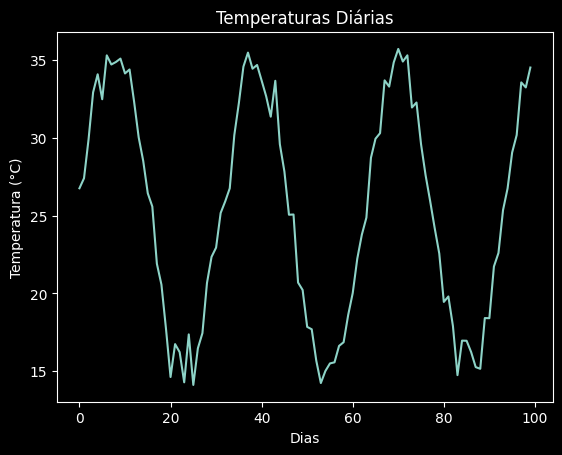

In [4]:
# Visualizando os dados de temperatura para ter uma ideia das tendências

plt.plot(df)
plt.title("Temperaturas Diárias")
plt.xlabel("Dias")
plt.ylabel("Temperatura (°C)")
plt.show()

## Passo 3: Pré-processamento dos Dados

In [5]:
# Descrição sobre os dados
df.describe()

,Temperatura
count,100.000000
mean,25.397457
std,7.121059
min,14.111822
25%,18.279110
50%,25.752451
75%,32.374100
max,35.729000


In [6]:
# Informações sobre os dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperatura  100 non-null    float64
dtypes: float64(1)
memory usage: 932.0 bytes


In [7]:
# Normalizando os dados para que fiquem entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(df)
# Exibindo os dados normalizados
data_normalized[:5]

array([[0.58528593],
       [0.61501199],
       [0.73082073],
       [0.87085428],
       [0.92451296]])

## Passo 4: Construção da Rede LSTM

In [8]:
# Criando a sequências para treinamento
def criar_sequencias(dataset, janela=10):
    X, y = [], []
    for i in range(len(dataset) - janela):
        X.append(dataset[i:i+janela])
        y.append(dataset[i+janela])
    return np.array(X), np.array(y)

In [9]:
# Definindo a janela deslizante (exemplo: últimos 10 dias)
janela = 10  
dados = df["Temperatura"].values

X, y = criar_sequencias(dados, janela)

In [ ]:
# Separando 80% para treino e 20% para teste
divisao = int(len(X) * 0.8)
X_treino, X_teste = X[:divisao], X[divisao:]
y_treino, y_teste = y[:divisao], y[divisao:]

# Redimensionando para formato adequado 
X_treino = X_treino.reshape((X_treino.shape[0], X_treino.shape[1], 1))
X_teste = X_teste.reshape((X_teste.shape[0], X_teste.shape[1], 1))

In [11]:
# Criando o modelo
modelo = Sequential([
    LSTM(50, return_sequences=True, input_shape=(janela, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compilando o modelo
modelo.compile(optimizer="adam", loss="mse")

# Resumo do modelo
modelo.summary()

c:\Labs\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Treinando o modelo
modelo.fit(
    X_treino, y_treino, epochs=50, batch_size=16, 
    validation_data=(X_teste, y_teste), verbose=1
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 646.2950 - val_loss: 510.0446
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 637.5254 - val_loss: 443.0676
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 551.5989 - val_loss: 365.3778
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 435.4196 - val_loss: 288.8696
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 375.2736 - val_loss: 219.6305
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 285.8524 - val_loss: 157.3325
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 227.1415 - val_loss: 106.0686
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 135.2161 - val_loss: 71.4501
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 105.5459 - val_loss: 52.6876
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 74.2327 - val_loss: 47.1999
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 55.7818 - val_loss: 49.6029
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/s

## Passo 5: Avaliação e Previsão

In [13]:
# Fazendo as previsões
y_pred = modelo.predict(X_teste)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


In [14]:
# Revertendo a normalização
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_teste = scaler.inverse_transform(y_teste.reshape(-1, 1))

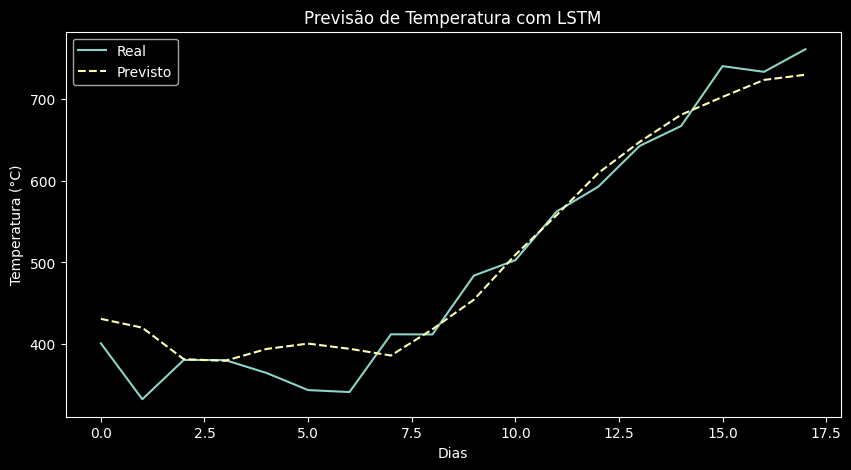

In [15]:
# Visualizando os resultados
plt.figure(figsize=(10, 5))
plt.plot(y_teste, label="Real")
plt.plot(y_pred, label="Previsto", linestyle="dashed")
plt.legend()
plt.xlabel("Dias")
plt.ylabel("Temperatura (°C)")
plt.title("Previsão de Temperatura com LSTM")
plt.show()